# Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


Working with CUDA capabilities.

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


# Loading the train data set

In [3]:
data_dir = '../../Images/june5Night/Positive/'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

We see 20 batches of 15 images each. Becasue we have in total 295 of positive images.

In [5]:
print(len(dataloader))

20


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0005) tensor(1.)


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

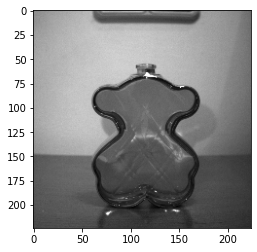

In [7]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

Now, cropping the image to be of size 160x160.

In [8]:
TOP_CROP_POS = 50
LEFT_CROP_POS = 35

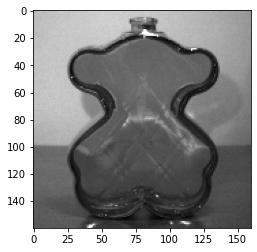

In [9]:

imgs_croped = transforms.functional.crop(images, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
single_img = imgs_croped[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.cpu().detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 160, 160.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 55           # ~= 110/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        output_channels_layer2 = output_channels*2+5
        output_channels_layer3 = output_channels_layer2*2

        self.conv2d_1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_2 = nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val)
        self.conv2d_3 = nn.Conv2d(output_channels_layer2, output_channels_layer3, 5)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        self.encoder_tanh = nn.Tanh()
        self.decoder_tanh = nn.Tanh()
        self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)

        self.convTranspose2d_1 = nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 5)
        self.convTranspose2d_2 = nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=4)
        self.convTranspose2d_3 = nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=3)
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            output = x
            print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            print("self.conv2d_3 shape is: ", output.shape)

            print("The LINEAR and TANH layers")
            output = output.view(output.size(0), -1)
            print("output.view shape is: ", output.shape)
            output = self.fc(output)
            print("self.fc shape is: ", output.shape)
            output = self.encoder_tanh(output)
            print("self.encoder_tanh shape is: ", output.shape)

            output = self.decoder_tanh(output)
            print("self.decoder_tanh shape is: ", output.shape)
            output = self.decoder_fc(output)
            print("self.decoder_fc shape is: ", output.shape)
            output = output.view(-1, output.size(1), 1, 1)
            print("output.view shape is: ", output.shape)
            

            print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            print("self.sigmoid shape is: ", output.shape)

            print("Finish the FORWARD function")
        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            output = x
            # print("The input image shape is: ", output.shape)
            output = self.conv2d_1(output)
            # print("self.conv2d_1 shape is: ", output.shape)
            output = self.relu1(output)
            output = self.conv2d_2(output)
            # print("self.conv2d_2 shape is: ", output.shape)
            output = self.relu2(output)
            output = self.conv2d_3(output)
            # print("self.conv2d_3 shape is: ", output.shape)

            # print("The LINEAR and TANH layers")
            output = output.view(output.size(0), -1)
            # print("output.view shape is: ", output.shape)
            output = self.fc(output)
            # print("self.fc shape is: ", output.shape)
            output = self.encoder_tanh(output)
            # print("self.encoder_tanh shape is: ", output.shape)

            output = self.decoder_tanh(output)
            # print("self.decoder_tanh shape is: ", output.shape)
            output = self.decoder_fc(output)
            # print("self.decoder_fc shape is: ", output.shape)
            output = output.view(-1, output.size(1), 1, 1)
            # print("output.view shape is: ", output.shape)
            

            # print("The DECODER part is executing")
            output = self.convTranspose2d_1(output)
            # print("self.convTranspose2d_1 shape is: ", output.shape)
            output = self.relu3(output)
            output = self.convTranspose2d_2(output)
            # print("self.convTranspose2d_2 shape is: ", output.shape)
            output = self.relu4(output)
            output = self.convTranspose2d_3(output)
            # print("self.convTranspose2d_3 shape is: ", output.shape)
            output = self.sigmoid(output)
            # print("self.sigmoid shape is: ", output.shape)

            # print("Finish the FORWARD function")
        return output
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [12]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)
model.to(device)

Autoencoder(
  (conv2d_1): Conv2d(3, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_2): Conv2d(55, 115, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
  (conv2d_3): Conv2d(115, 230, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (fc): Linear(in_features=230, out_features=230, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=230, out_features=230, bias=True)
  (convTranspose2d_1): ConvTranspose2d(230, 115, kernel_size=(5, 5), stride=(1, 1))
  (convTranspose2d_2): ConvTranspose2d(115, 55, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(4, 4))
  (convTranspose2d_3): ConvTranspose2d(55, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(3, 3))
  (relu3): ReLU()
  (relu4): ReLU()
  (sigmoid): Sigmoid()
)

In [13]:
num_epochs = 1
outputs = []
for epoch in range(num_epochs):
    for i, (img, _) in enumerate(dataloader):
        if i == 1:
            break
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img.cuda(), TOP_CROP_POS, LEFT_CROP_POS, 160, 160)
        single_img = imgs_croped[0]
        image_in_tensor = single_img[None, :].cuda()
        print(image_in_tensor.shape)
        # Forward pass
        recon = model(image_in_tensor,True)          # The entire batch of images is passed to the model
        loss = criterion(recon, image_in_tensor)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

torch.Size([1, 3, 160, 160])
The FORWARD function is starting
The ENCODER part is executing
The input image shape is:  torch.Size([1, 3, 160, 160])
self.conv2d_1 shape is:  torch.Size([1, 55, 31, 31])
self.conv2d_2 shape is:  torch.Size([1, 115, 5, 5])
self.conv2d_3 shape is:  torch.Size([1, 230, 1, 1])
The LINEAR and TANH layers
output.view shape is:  torch.Size([1, 230])
self.fc shape is:  torch.Size([1, 230])
self.encoder_tanh shape is:  torch.Size([1, 230])
self.decoder_tanh shape is:  torch.Size([1, 230])
self.decoder_fc shape is:  torch.Size([1, 230])
output.view shape is:  torch.Size([1, 230, 1, 1])
The DECODER part is executing
self.convTranspose2d_1 shape is:  torch.Size([1, 115, 5, 5])
self.convTranspose2d_2 shape is:  torch.Size([1, 55, 31, 31])
self.convTranspose2d_3 shape is:  torch.Size([1, 3, 160, 160])
self.sigmoid shape is:  torch.Size([1, 3, 160, 160])
Finish the FORWARD function
Epoch:1, Loss:0.0450


In [14]:
torch.cuda.empty_cache()

# Training the model

In [15]:
val_dir_for_training = '../../Images/june5Night/Positive_val'      #This is for the home laptop

transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_val_for_training = datasets.ImageFolder(val_dir_for_training, transform=transform_characteristics)
dataloader_val_for_training = torch.utils.data.DataLoader(dataset_val_for_training, batch_size=15, shuffle=True)
print(len(dataloader_val_for_training))

2


Actually training the model with early stopping and storing the loss function values accross all epochs.

Here we can see that we need to store in a vector the loss of each batch to compute its average for later. loss.item() will only return the last loss value, but not the average of the losses of the first epoch.

In [19]:
epochs_toCheck_earlyStopping = 10
min_diff_earlyStopping = 0.0005
# Point to training loop video
num_epochs = 300
outputs = []
prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
losses_list = []

for epoch in range(num_epochs):
    if epoch == 1:
        break
    for (img, _) in dataloader:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        loss = criterion(recon, imgs_croped)
        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

        print(loss)


    # for (img, _) in dataloader_val_for_training:     # This iterates over the batches of images.
    #     img = img.to(device)
    #     imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

    #     # Forward pass
    #     recon_val = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
    #     loss_val = criterion(recon_val, imgs_croped)

    print(f'Epoch:{epoch+1}, Training loss:{loss.item():.4f}')
    print(loss)
    print(type(loss))
    print(loss.shape)
    print(loss.item())

tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=

In [35]:
epochs_toCheck_earlyStopping = 10
min_diff_earlyStopping = 0.0005
# Point to training loop video
num_epochs = 300
outputs = []
prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
losses_list = []
losses_avg_list = []

losses_val_list = []
losses_val_avg_list = []

for epoch in range(num_epochs):
    if epoch == 1:
        break
    for (img, _) in dataloader:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        loss = criterion(recon, imgs_croped)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 
        losses_list.append(loss.item())
    
    loss_avg_epoch = np.mean(losses_list[-len(dataloader):])
    losses_avg_list.append(loss_avg_epoch)

    for (img, _) in dataloader_val_for_training:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon_val = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        losses_val = criterion(recon_val, imgs_croped)
        losses_val_list.append(losses_val.item())

    loss_val_avg_epoch = np.mean(losses_val_list[-len(dataloader_val_for_training):])
    losses_val_avg_list.append(loss_val_avg_epoch)

    print(f'Epoch:{epoch+1}, average training loss:{loss_avg_epoch:.4f}, average validation loss:{loss_val_avg_epoch:.4f}')

    # Calculate the average loss for the current epoch
#     avg_loss = loss.item()
#     losses_list.append(avg_loss)
#     # Append the current loss to the previous losses list
#     prev_losses.append(avg_loss)
#     prev_losses = prev_losses[1:]  # Keep only the last 5 losses

#     # Check if the last 5 losses are the same (within a tolerance)
#     stop_training = all(abs(loss - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

#     # Break the training loop if the stopping condition is met
#     if stop_training:
#         print('Early stopping triggered. Training stopped.')
#         break

# # open file
# with open('RecErrorLossesList_croppedImages.txt', 'w+') as g:
#     # write elements of list
#     for items in losses_list:
#         g.write('%s\n' %items)
#     print("losses_list written successfully")
# # close the file
# g.close() 

Epoch:1, average training loss:0.0100, average validation loss:0.0106


In [36]:
print("the training losses list is:")
print(losses_list)
print("the validation losses list is:")
print(losses_val_list)

the training losses list is:
[0.010385752655565739, 0.009098220616579056, 0.011517775245010853, 0.00916680321097374, 0.010889241471886635, 0.008088182657957077, 0.01055364403873682, 0.011191418394446373, 0.00947587937116623, 0.011865629814565182, 0.009041962213814259, 0.010576507076621056, 0.01005510427057743, 0.00871476624161005, 0.009497484192252159, 0.008970060385763645, 0.00934361107647419, 0.012837381102144718, 0.009139719419181347, 0.010497402399778366]
the validation losses list is:
[0.011047005653381348, 0.010119632817804813]


In [65]:
epochs_toCheck_earlyStopping = 4
min_diff_earlyStopping = 0.0001
# Point to training loop video
num_epochs = 300
outputs = []
prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
losses_list = []
losses_avg_list = []

losses_val_list = []
losses_val_avg_list = []

for epoch in range(num_epochs):
    if epoch == 8:
        break
    for (img, _) in dataloader:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        loss = criterion(recon, imgs_croped)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 
        losses_list.append(loss.item())  

    for (img, _) in dataloader_val_for_training:     # This iterates over the batches of images.
        img = img.to(device)
        imgs_croped = transforms.functional.crop(img, TOP_CROP_POS, LEFT_CROP_POS, 160, 160)

        # Forward pass
        recon_val = model(imgs_croped.cuda())          # The entire batch of images is passed to the model
        losses_val = criterion(recon_val, imgs_croped)
        losses_val_list.append(losses_val.item())

    loss_avg_epoch = np.mean(losses_list[-len(dataloader):])
    losses_avg_list.append(loss_avg_epoch)
    
    loss_val_avg_epoch = np.mean(losses_val_list[-len(dataloader_val_for_training):])
    losses_val_avg_list.append(loss_val_avg_epoch)

    print(f'Epoch:{epoch+1}, average training loss:{loss_avg_epoch:.4f}, average validation loss:{loss_val_avg_epoch:.4f}')

    # Append the current validation loss to the previous losses list
    prev_losses.append(loss_val_avg_epoch)
    prev_losses = prev_losses[-epochs_toCheck_earlyStopping:]  # Keep only the last 10 losses
    print(prev_losses)
    # Check if the last 5 losses are the same (within a tolerance)
    stop_training = all(abs(loss_val_avg_epoch - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

    # Break the training loop if the stopping condition is met
    if stop_training:
        print('Early stopping triggered. Training stopped.')
        break

# open file
with open('losseslistTrain.txt', 'w+') as g:
    # write elements of list
    for items in losses_list:
        g.write('%s\n' %items)
    print("losseslistTrain written successfully")
# close the file
g.close() 

# open file
with open('losseslist_avg_Train.txt', 'w+') as g:
    # write elements of list
    for items in losses_avg_list:
        g.write('%s\n' %items)
    print("losseslist_avg_Train written successfully")
# close the file
g.close()

# open file
with open('losseslistVal.txt', 'w+') as g:
    # write elements of list
    for items in losses_val_list:
        g.write('%s\n' %items)
    print("losseslistVal written successfully")
# close the file
g.close() 

# open file
with open('losses_avg_Val.txt', 'w+') as g:
    # write elements of list
    for items in losses_val_avg_list:
        g.write('%s\n' %items)
    print("losseslist_avg_Val written successfully")
# close the file
g.close()

Epoch:1, average training loss:0.0085, average validation loss:0.0114
[inf, inf, inf, 0.011351643363013864]
Epoch:2, average training loss:0.0083, average validation loss:0.0092
[inf, inf, 0.011351643363013864, 0.009176939260214567]
Epoch:3, average training loss:0.0083, average validation loss:0.0093
[inf, 0.011351643363013864, 0.009176939260214567, 0.009320273995399475]
Epoch:4, average training loss:0.0082, average validation loss:0.0101
[0.011351643363013864, 0.009176939260214567, 0.009320273995399475, 0.010076873004436493]
Epoch:5, average training loss:0.0081, average validation loss:0.0088
[0.009176939260214567, 0.009320273995399475, 0.010076873004436493, 0.008823462296277285]
Epoch:6, average training loss:0.0080, average validation loss:0.0089
[0.009320273995399475, 0.010076873004436493, 0.008823462296277285, 0.008935562334954739]
Epoch:7, average training loss:0.0078, average validation loss:0.0086
[0.010076873004436493, 0.008823462296277285, 0.008935562334954739, 0.008620353